# Reto Coppel


## Importación de librerías

In [80]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (col, lit,
                                   isnan, when, count, sum, countDistinct,
                                   year, month, day, dayofweek,
                                   lower)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

## Conexión al servidor

In [31]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

## Carga de datos

In [32]:
df = spark.read.csv("../dataset.csv", header=True, inferSchema=True)
for col_name in df.columns:
    df = df.withColumnRenamed(col_name, col_name.capitalize())

## Inspección

In [33]:
df.show(5)

+------+----------+--------+------------------+------------------+------------------+------+--------+--------+----------------+
|   _c0|     Fecha|Segmento|      Hora_llegada|      Hora_llamado|       Hora_salida|  Caja|  Tienda|  Status|          Estado|
+------+----------+--------+------------------+------------------+------------------+------+--------+--------+----------------+
|821243|2023-01-01|  retail|0.5034652777777778|0.5034768518518519|0.5035810185185186|caja_a|Tienda_A|Atendido|Ciudad de México|
|821244|2023-01-01|  retail|0.5035810185185186|0.5036157407407408|0.5111736111111111|caja_a|Tienda_A|Atendido|Ciudad de México|
|821245|2023-01-01|  retail|0.5037893518518518| 0.503800925925926|0.5051203703703704|caja_b|Tienda_A|Atendido|Ciudad de México|
|821246|2023-01-01|  retail|0.5038472222222222|0.5051319444444444|0.5093333333333333|caja_b|Tienda_A|Atendido|Ciudad de México|
|821247|2023-01-01|  retail|0.5038935185185185|0.5080717592592593|0.5099814814814815|caja_c|Tienda_A|Ate

In [34]:
print((df.count(), len(df.columns)))

(18510772, 10)


### Tipos de datos

In [35]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Fecha: date (nullable = true)
 |-- Segmento: string (nullable = true)
 |-- Hora_llegada: double (nullable = true)
 |-- Hora_llamado: double (nullable = true)
 |-- Hora_salida: double (nullable = true)
 |-- Caja: string (nullable = true)
 |-- Tienda: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Estado: string (nullable = true)



El tipo de dato de cada atributo corresponde a la naturaleza del atributo.

### Valores nulos

In [36]:
df.agg(*[sum(col(column).isNull().cast("int")).alias(column) for column in df.columns]).show()

+---+-----+--------+------------+------------+-----------+----+------+------+------+
|_c0|Fecha|Segmento|Hora_llegada|Hora_llamado|Hora_salida|Caja|Tienda|Status|Estado|
+---+-----+--------+------------+------------+-----------+----+------+------+------+
|  0|    0|       0|           0|           0|          0|   0|     0|     0|     0|
+---+-----+--------+------------+------------+-----------+----+------+------+------+



No hay valores nulos.

### Valores únicos

In [37]:
df.select(col("Segmento")).distinct().show()

+----------+
|  Segmento|
+----------+
|     banco|
|    retail|
|afiliacion|
+----------+



Hay tres tipos de segmento que corresponden a los siguientes tipos: \
Banco: Bancoppel \
Retail: Coppel \
Afiliación: Promotoría

In [38]:
df.select(col("Caja")).distinct().show(df.count())

+------------+
|        Caja|
+------------+
|      caja_j|
|         p_d|
|      caja_p|
|      caja_f|
|         p_h|
|      caja_l|
|ventanilla_c|
|ventanilla_g|
|         p_l|
|      caja_q|
|         p_p|
|         p_m|
|      caja_n|
|         p_k|
|      caja_i|
|         p_e|
|      caja_b|
|         p_g|
|         p_b|
|ventanilla_b|
|         p_f|
|         p_a|
|ventanilla_a|
|         p_o|
|      caja_d|
|      caja_e|
|ventanilla_e|
|         p_j|
|      caja_k|
|         p_n|
|      caja_a|
|         p_c|
|      caja_m|
|      caja_o|
|      caja_h|
|ventanilla_f|
|      caja_c|
|ventanilla_d|
|         p_i|
|         a_a|
|         a_b|
|         p_r|
|         p_q|
|      caja_r|
|      caja_t|
|         p_s|
|      caja_s|
|ventanilla_i|
|ventanilla_n|
|ventanilla_m|
|         p_v|
|         p_y|
|ventanilla_l|
|      Caja_d|
|      caja_v|
|         p_u|
|      Caja_f|
|      Caja_b|
|         p_z|
|         P_a|
|         p_t|
|ventanilla_h|
|ventanilla_o|
|      Caj

Se tienen 77 cajas distintas que se dividen en tres tipos: caja, ventanilla, p. Hay errores de etiquetado.

In [39]:
df.groupBy(["Segmento", "Caja"]).agg(countDistinct("Caja").alias("Cajas_distintas")).show(df.count())

+----------+------------+---------------+
|  Segmento|        Caja|Cajas_distintas|
+----------+------------+---------------+
|     banco|ventanilla_b|              1|
|    retail|      caja_k|              1|
|    retail|      caja_a|              1|
|     banco|      caja_l|              1|
|afiliacion|         p_a|              1|
|     banco|      caja_k|              1|
|     banco|         p_f|              1|
|afiliacion|ventanilla_f|              1|
|     banco|      caja_d|              1|
|    retail|ventanilla_a|              1|
|afiliacion|      caja_n|              1|
|afiliacion|      caja_a|              1|
|afiliacion|         p_o|              1|
|    retail|      caja_d|              1|
|afiliacion|         p_c|              1|
|    retail|         p_k|              1|
|     banco|      caja_b|              1|
|    retail|      caja_i|              1|
|     banco|      caja_o|              1|
|afiliacion|      caja_h|              1|
|     banco|         p_b|         

Cada segmento tiene diferentes cajas.

In [40]:
df.groupBy("Segmento").agg(countDistinct("Caja").alias("Cajas_distintas")).show()

+----------+---------------+
|  Segmento|Cajas_distintas|
+----------+---------------+
|     banco|             75|
|    retail|             74|
|afiliacion|             62|
+----------+---------------+



In [41]:
df.select(col("Tienda")).distinct().show(df.count())

+---------+
|   Tienda|
+---------+
| Tienda_G|
|Tienda_AE|
|Tienda_AI|
|Tienda_AD|
|Tienda_AH|
| Tienda_M|
| Tienda_U|
| Tienda_L|
|Tienda_AX|
|Tienda_BD|
|Tienda_AG|
| Tienda_D|
|Tienda_AB|
|Tienda_AK|
|Tienda_AF|
|Tienda_AJ|
|Tienda_AM|
| Tienda_P|
| Tienda_R|
| Tienda_V|
| Tienda_O|
| Tienda_I|
| Tienda_N|
| Tienda_A|
| Tienda_B|
|Tienda_BB|
|Tienda_AA|
| Tienda_S|
|Tienda_AN|
|Tienda_AP|
| Tienda_X|
| Tienda_Z|
| Tienda_E|
|Tienda_AO|
|Tienda_BE|
|Tienda_AY|
| Tienda_T|
|Tienda_AC|
|Tienda_BC|
| Tienda_J|
|Tienda_AL|
| Tienda_Q|
| Tienda_H|
|Tienda_BA|
|Tienda_AZ|
| Tienda_Y|
| Tienda_F|
| Tienda_K|
|Tienda_AQ|
| Tienda_C|
+---------+



Se tienen 50 tiendas distintas.

In [42]:
df.select(col("Status")).distinct().show()

+--------+
|  Status|
+--------+
| Ausente|
|Atendido|
+--------+



In [43]:
df.select(col("Estado")).distinct().show(df.count())

+--------------------+
|              Estado|
+--------------------+
|    Ciudad de México|
|             Sinaloa|
| Michoacán de Ocampo|
|             Durango|
|            Guerrero|
|             Chiapas|
|          Guanajuato|
|Coahuila de Zaragoza|
|           Chihuahua|
|             Morelos|
|Veracruz de Ignac...|
|             Yucatán|
|             Tabasco|
|              Oaxaca|
| Baja California Sur|
|              Puebla|
|          Nuevo León|
|           Zacatecas|
|           Querétaro|
|        Quintana Roo|
|              Sonora|
|              México|
|     Baja California|
+--------------------+



Se incluyen solo 23 estados de la república.

Hay errores de etiquetado en el atributo *Caja*.

## Limpieza de datos

### Errores de etiquetado

Corrijamos errores de etiquetado, en este caso, cambiemos todos los valores del atributo *Caja* a minusculas para que no haya valores repetidos que se identifiquen como distintos por el uso de mayusculas.

In [44]:
df = df.withColumn("Caja", lower(col("Caja")))
df.select(col("Caja")).distinct().show()

+------------+
|        Caja|
+------------+
|      caja_j|
|         p_d|
|      caja_p|
|      caja_f|
|         p_h|
|      caja_l|
|ventanilla_c|
|ventanilla_g|
|         p_l|
|      caja_q|
|         p_p|
|         p_m|
|      caja_n|
|         p_k|
|      caja_i|
|         p_e|
|      caja_b|
|         p_g|
|         p_b|
|ventanilla_b|
+------------+
only showing top 20 rows



Cambios a minusculas los valores de los demas atributos para ser consistentes con los etiquetados.

In [54]:
df = df.withColumn("Tienda", lower(col("Tienda")))
df.select(col("Tienda")).distinct().show()

+---------+
|   Tienda|
+---------+
|tienda_ax|
|tienda_aq|
|tienda_bb|
|tienda_ac|
| tienda_f|
| tienda_g|
|tienda_bc|
| tienda_t|
| tienda_v|
| tienda_x|
| tienda_z|
|tienda_ah|
| tienda_l|
| tienda_n|
|tienda_af|
| tienda_m|
| tienda_p|
|tienda_ao|
| tienda_a|
|tienda_ak|
+---------+
only showing top 20 rows



In [55]:
df = df.withColumn("Status", lower(col("Status")))
df.select(col("Status")).distinct().show()

+--------+
|  Status|
+--------+
|atendido|
| ausente|
+--------+



### Ruido

Eliminemos las observaciones donde la hora de llegada es mayor que la hora de llamado o salida y las observaciones donde su hora de llamado es mayor al horario de salida

In [45]:
df = df.filter((col("Hora_llegada") < col("Hora_llamado")) &
          (col("Hora_llegada") < col("Hora_salida")) &
          (col("Hora_llamado") < col("Hora_salida")))
print((df.count(), len(df.columns)))

(18100185, 10)


Se eliminaron 400,000 observaciones, aproximadamente.

## Creación de nuevas columnas

Separemos el atributo compuesto *Fecha* en tres atributos: *Dia*, *Mes* y *Anio*.

In [46]:
df = df.withColumn("Anio", year(col("Fecha")))
df = df.withColumn("Mes", month(col("Fecha")))
df = df.withColumn("Dia", day(col("Fecha")))
df.show(5)

+------+----------+--------+------------------+------------------+------------------+------+--------+--------+----------------+----+---+---+
|   _c0|     Fecha|Segmento|      Hora_llegada|      Hora_llamado|       Hora_salida|  Caja|  Tienda|  Status|          Estado|Anio|Mes|Dia|
+------+----------+--------+------------------+------------------+------------------+------+--------+--------+----------------+----+---+---+
|821243|2023-01-01|  retail|0.5034652777777778|0.5034768518518519|0.5035810185185186|caja_a|Tienda_A|Atendido|Ciudad de México|2023|  1|  1|
|821244|2023-01-01|  retail|0.5035810185185186|0.5036157407407408|0.5111736111111111|caja_a|Tienda_A|Atendido|Ciudad de México|2023|  1|  1|
|821245|2023-01-01|  retail|0.5037893518518518| 0.503800925925926|0.5051203703703704|caja_b|Tienda_A|Atendido|Ciudad de México|2023|  1|  1|
|821246|2023-01-01|  retail|0.5038472222222222|0.5051319444444444|0.5093333333333333|caja_b|Tienda_A|Atendido|Ciudad de México|2023|  1|  1|
|821247|2023-

In [47]:
df.select(col("Anio")).distinct().show()

+----+
|Anio|
+----+
|2023|
|2024|
+----+



In [48]:
df.select(col("Mes")).distinct().show()

+---+
|Mes|
+---+
|  1|
|  2|
|  3|
|  4|
|  5|
|  6|
|  7|
|  8|
|  9|
| 10|
| 11|
| 12|
+---+



In [49]:
df.select(col("Dia")).distinct().orderBy(col("Dia")).show(31)

+---+
|Dia|
+---+
|  1|
|  2|
|  3|
|  4|
|  5|
|  6|
|  7|
|  8|
|  9|
| 10|
| 11|
| 12|
| 13|
| 14|
| 15|
| 16|
| 17|
| 18|
| 19|
| 20|
| 21|
| 22|
| 23|
| 24|
| 25|
| 26|
| 27|
| 28|
| 29|
| 30|
| 31|
+---+



In [50]:
df = df.withColumn("Dia_semana", dayofweek(col("Fecha")))
df.show(5)

+------+----------+--------+------------------+------------------+------------------+------+--------+--------+----------------+----+---+---+----------+
|   _c0|     Fecha|Segmento|      Hora_llegada|      Hora_llamado|       Hora_salida|  Caja|  Tienda|  Status|          Estado|Anio|Mes|Dia|Dia_semana|
+------+----------+--------+------------------+------------------+------------------+------+--------+--------+----------------+----+---+---+----------+
|821243|2023-01-01|  retail|0.5034652777777778|0.5034768518518519|0.5035810185185186|caja_a|Tienda_A|Atendido|Ciudad de México|2023|  1|  1|         1|
|821244|2023-01-01|  retail|0.5035810185185186|0.5036157407407408|0.5111736111111111|caja_a|Tienda_A|Atendido|Ciudad de México|2023|  1|  1|         1|
|821245|2023-01-01|  retail|0.5037893518518518| 0.503800925925926|0.5051203703703704|caja_b|Tienda_A|Atendido|Ciudad de México|2023|  1|  1|         1|
|821246|2023-01-01|  retail|0.5038472222222222|0.5051319444444444|0.5093333333333333|caj

In [53]:
df.select(col("Dia_semana")).distinct().orderBy(col("Dia_semana")).show()

+----------+
|Dia_semana|
+----------+
|         1|
|         2|
|         3|
|         4|
|         5|
|         6|
|         7|
+----------+



Creemos una nueva columna que sea la diferencia de los atributos *Hora_llamado* y *Hora_llegada* para su posterior análisis.

In [57]:
df = df.withColumn("Tiempo_espera", col("Hora_llamado") - col("Hora_llegada"))
df.show(5)

+------+----------+--------+------------------+------------------+------------------+------+--------+--------+----------------+----+---+---+----------+--------------------+
|   _c0|     Fecha|Segmento|      Hora_llegada|      Hora_llamado|       Hora_salida|  Caja|  Tienda|  Status|          Estado|Anio|Mes|Dia|Dia_semana|       Tiempo_espera|
+------+----------+--------+------------------+------------------+------------------+------+--------+--------+----------------+----+---+---+----------+--------------------+
|821243|2023-01-01|  retail|0.5034652777777778|0.5034768518518519|0.5035810185185186|caja_a|tienda_a|atendido|Ciudad de México|2023|  1|  1|         1|1.157407407403887...|
|821244|2023-01-01|  retail|0.5035810185185186|0.5036157407407408|0.5111736111111111|caja_a|tienda_a|atendido|Ciudad de México|2023|  1|  1|         1|3.472222222222765E-5|
|821245|2023-01-01|  retail|0.5037893518518518| 0.503800925925926|0.5051203703703704|caja_b|tienda_a|atendido|Ciudad de México|2023|  1

## Análisis exploratorio de datos

Tomemos una muestra estratificada por mes para asegurarnos que incluya observaciones de cada mes. La muestra es necesaria para la eficiencia computacional.

In [95]:
muestra = df.sampleBy(col("Mes"),
            fractions={1: 0.01, 2: 0.01, 3: 0.01, 4: 0.01, 5: 0.01, 6: 0.01,
                       7: 0.01, 8: 0.01, 9: 0.01, 10: 0.01, 11: 0.01, 12: 0.01},
            seed=42).toPandas()
print(muestra.shape)

(181601, 15)


### Clientes por mes

**Descripción numérica**

In [141]:
clientes_por_mes = df.groupby("Mes").count().withColumnRenamed("count", "Clientes").toPandas()
clientes_por_mes.head(12)

,Mes,Clientes
0,1,2302042
1,2,1095886
2,3,1355283
3,4,1280674
4,5,1500560
5,6,1483479
6,7,1604371
7,8,1538614
8,9,1501441
9,10,1454802


**Descripción gráfica**

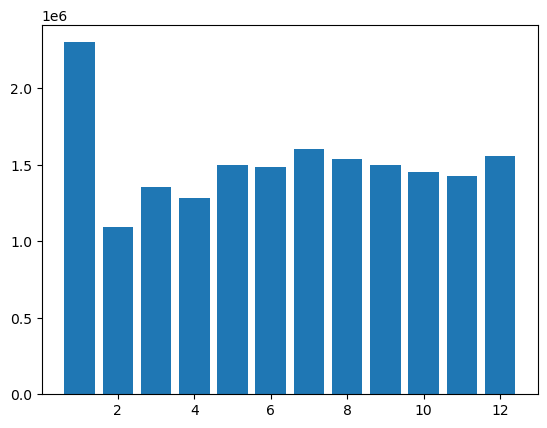

In [142]:
plt.bar(clientes_por_mes.Mes, clientes_por_mes.Clientes)
plt.show()

Podemos observar que el mes en el que entran más clientes es enero, le sigue julio y diciembre.

### Clientes atendidos y ausentes por mes

**Descripción numérica**

In [147]:
ausentes_por_mes = df.groupby(["Mes", "Status"]).count().withColumnRenamed("count", "Clientes").toPandas()
ausentes_por_mes.head(24)

,Mes,Status,Clientes
0,2,ausente,67151
1,2,atendido,1028735
2,1,ausente,148615
3,1,atendido,2153427
4,3,atendido,1268685
5,3,ausente,86598
6,4,ausente,79974
7,4,atendido,1200700
8,5,ausente,98806
9,5,atendido,1401754


### Tiempo de espera

**Descripción numérica**

In [63]:
df.select(col("Tiempo_espera")).describe().show()

+-------+--------------------+
|summary|       Tiempo_espera|
+-------+--------------------+
|  count|            18100185|
|   mean|0.005099834542684433|
| stddev|0.011330062165644965|
|    min|1.157407407398336...|
|    max|  0.5003819444444444|
+-------+--------------------+



In [64]:
df.approxQuantile("Tiempo_espera", [0.25, 0.5, 0.75], 0.01)

[0.0003240740740740877, 0.001782407407407427, 0.005254629629629637]

Podemos notar una asimetría a la derecha.

**Descripción gráfica**

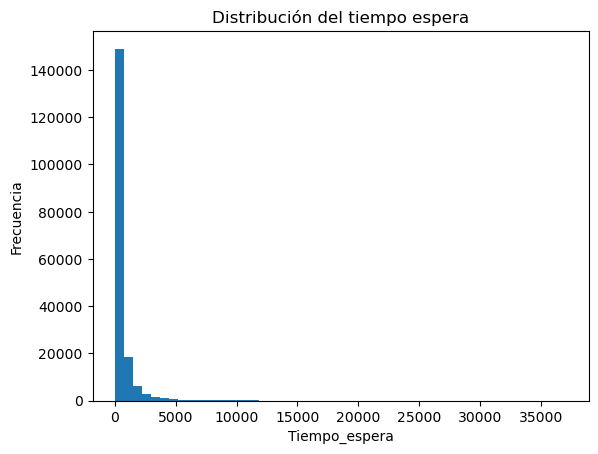

In [107]:
plt.hist(muestra.Tiempo_espera, bins=50)
plt.title("Distribución del tiempo espera")
plt.xlabel("Tiempo_espera")
plt.ylabel("Frecuencia")
plt.show()

### Tiempo de espera de clientes atendidos y ausentes

### Tiempo de espera promedio por mes

In [127]:
espera_prom_mes = muestra.groupby("Mes")["Tiempo_espera"].mean()

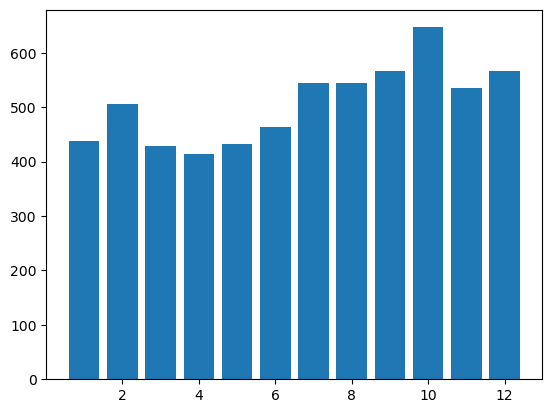

In [130]:
plt.bar(muestra.Mes.unique(), espera_prom_mes)
plt.title("C")
plt.show()

A pesar de que en el mes de enero entran más clientes a las tiendas, los tiempos son menores que los de los demás meses, por lo que es probable que se tenga más personal en este mes.

## Prueba hipótesis

Antes que nada, a pesar de que parezca obvio, sería buena práctica analizar si realmente existe una diferencia entre los tiempos de espera de clientes que fueron atendidos con los que se fueron antes de ser atendidos. Para esto usaremos prueba de permutación para diferencia de medias.

Transformemos los datos para evitar errores numéricos.

In [106]:
muestra["Tiempo_espera"] = 1000 * muestra["Tiempo_espera"]

H0: mu2 - mu1 = 0 \
H1: mu2 - mu1 != 0

In [116]:
# Valor observado
obs = (muestra[muestra["Status"] == "ausente"]["Tiempo_espera"].mean() -
       muestra[muestra["Status"] == "atendido"]["Tiempo_espera"].mean())
obs

679.5725655562512

In [112]:
B = 100
atendidos = muestra[muestra["Status"] == "atendido"]
ausente = muestra[muestra["Status"] == "ausente"]
diferencias_medias = []

for _ in range(B):
    etiquetas = np.random.permutation(muestra["Status"])
    diferencias_medias.append(muestra[etiquetas == "ausente"]["Tiempo_espera"].mean() -
                              muestra[etiquetas == "atendido"]["Tiempo_espera"].mean())

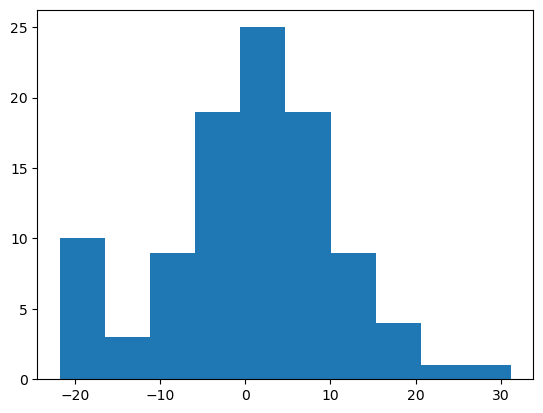

In [115]:
plt.hist(diferencias_medias)
plt.show()

In [114]:
np.sum(diferencias_medias >= obs)

0

Tenemos evidencia muy fuerte en contra de la hipotesis nula, es decir, tenemos suficiente evidencia estadística para creer que, en promedio, las personas que se ausentaron esperaron más que las personas que fueron atendidas.